In [2]:
import galsim
import tensorflow as tf
import tensorflow_hub as hub
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
STAMP_SIZE = 128
PIXEL_SCALE = 0.03

In [4]:
# Load autoencoder model
encoder = hub.Module('modules/vae_cosmos_128/encoder')
decoder = hub.Module('modules/vae_cosmos_128/decoder')

In [5]:
# Loads COSMOS sample
cosmos_cat = galsim.COSMOSCatalog()

In [6]:
batch_size =1
psf_in = tf.placeholder(shape=[batch_size, 128, 128, 1], dtype=tf.float32)
im_in = tf.placeholder(shape=[batch_size, 128, 128, 1], dtype=tf.float32)

code = encoder({'input':im_in, 'psf':psf_in})
reconstruction = decoder(code)

sess = tf.Session()
sess.run(tf.global_variables_initializer())

INFO:tensorflow:Saver not created because there are no variables in the graph to restore
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [7]:
# some interesting examples from the test set
indices = [81201, 80252, 80203,  81353,80315,
           81200, 80203, 81211, 80001, 81202, 81263, 80505, 80003]

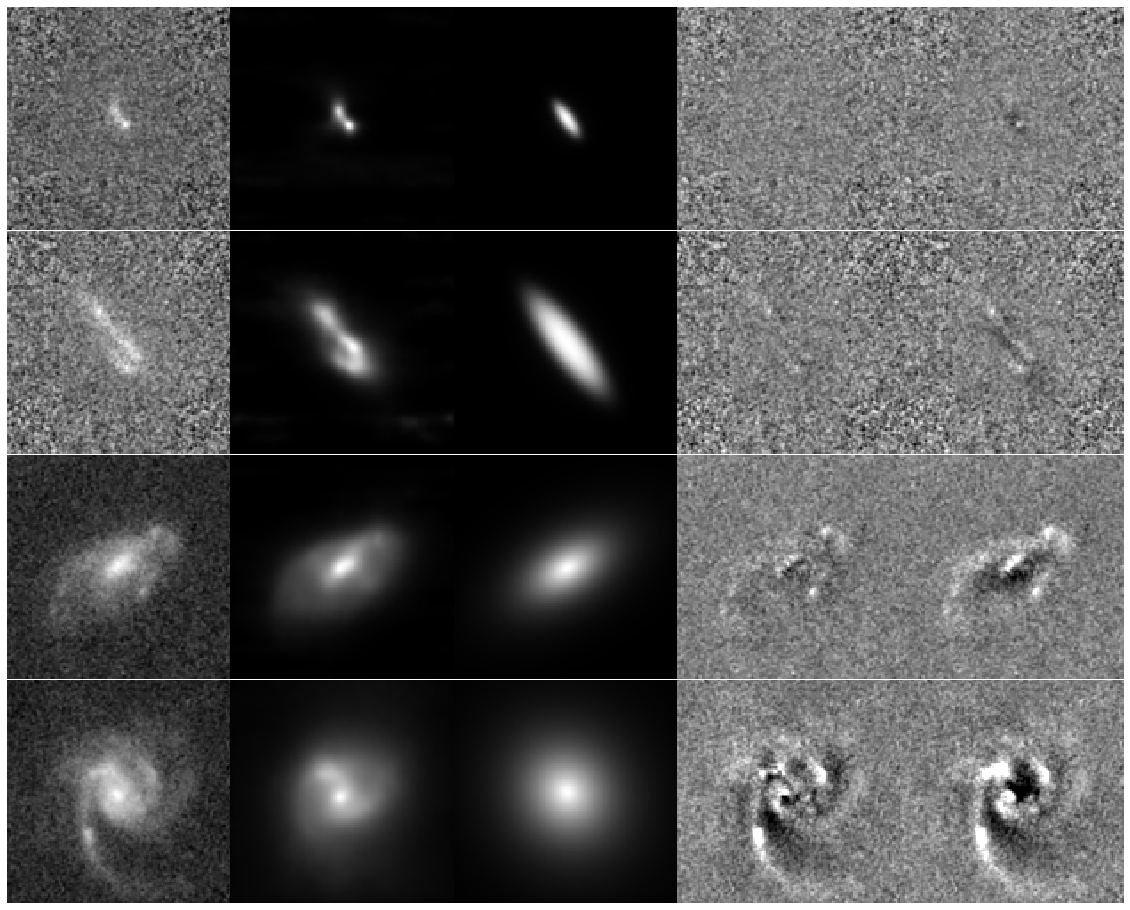

In [9]:
b=1
figure(figsize=(20,16.5))
for j in range(4):
    im_real = galsim.ImageF(STAMP_SIZE, STAMP_SIZE, scale=PIXEL_SCALE)
    im_sim = galsim.ImageF(STAMP_SIZE, STAMP_SIZE, scale=PIXEL_SCALE)
    im_param = galsim.ImageF(STAMP_SIZE, STAMP_SIZE, scale=PIXEL_SCALE)
    
    imCp = galsim.ImageCF(STAMP_SIZE, STAMP_SIZE, scale=2. * np.pi / (PIXEL_SCALE * STAMP_SIZE))

    i = indices[j]
    
    # Drawing galaxy from cosmos
    gal = cosmos_cat.makeGalaxy(i, gal_type='real')
    psf = gal.original_psf
    real = galsim.Convolve(psf, gal)
    real.drawImage(im_real, method='no_pixel');

    # Drawing autoencoded galaxy
    psf.drawKImage(image=imCp)
    im_psf = np.fft.fftshift(np.fft.ifft2(np.fft.fftshift(imCp.array))).real.astype('float32')
    x = sess.run(reconstruction, feed_dict={psf_in:im_psf.reshape((1,128,128,1)), im_in:im_real.array.reshape((1,128,128,1))})
    im = galsim.Image(np.ascontiguousarray(x.reshape((STAMP_SIZE, STAMP_SIZE)).astype(np.float64)), scale=PIXEL_SCALE)
    sim_gal = galsim.InterpolatedImage(im)
    sim = galsim.Convolve(psf, sim_gal)
    sim.drawImage(im_sim, method='no_pixel');
    
    # Drawing galaxy from parametric model
    param_gal = cosmos_cat.makeGalaxy(i, gal_type='parametric')
    param = galsim.Convolve(psf, param_gal)
    param.drawImage(im_param, method='no_pixel');

    subplot(4,5,1+j*5)
    imshow(arcsinh(50*im_real.array[b:-b,b:-b]), cmap='gray')
    axis('off')

    subplot(4,5,2+j*5)
    imshow(arcsinh(50*im_sim.array[b:-b,b:-b]), cmap='gray', vmin=0)   
    axis('off')
    
    subplot(4,5,3+j*5)
    imshow(arcsinh(50*im_param.array[b:-b,b:-b]), cmap='gray', vmin=0)   
    axis('off')

    subplot(4,5,4+j*5)
    imshow(im_real.array[b:-b,b:-b] - im_sim.array[b:-b,b:-b], cmap='gray', vmin=-0.02, vmax=0.02)   
    axis('off');

    subplot(4,5,5+j*5)
    imshow(im_real.array[b:-b,b:-b] - im_param.array[b:-b,b:-b], cmap='gray', vmin=-0.02, vmax=0.02)   
    axis('off');
    
    subplots_adjust(wspace=0, hspace=0)

subplots_adjust(wspace=0, hspace=0)
savefig('Figures/Figure_autoencode.pdf',bbox_inches='tight')